In [28]:
import random
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import accelerate
from transformers import TrainingArguments, Trainer, AutoTokenizer, AutoModelForSequenceClassification, DataCollatorWithPadding
from datasets import load_dataset, Dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, f1_score
from imblearn.metrics import geometric_mean_score

In [2]:
!rm -rf /kaggle/working/*

# Data

In [3]:
imppres_df = pd.read_csv('/kaggle/input/imppres/imppres.csv',index_col=0)
imppres_df = imppres_df.rename({'gold_label':'label'},axis=1)
imppres_df

,premise,hypothesis,label
0,All ten guys that proved to boast were divorcing.,There are exactly ten guys that proved to boast.,0
1,All ten guys that proved to boast were divorcing.,There are exactly eleven guys that proved to b...,2
2,All ten guys that proved to boast were divorcing.,There are exactly ten senators that proved to ...,1
3,All ten guys that proved to boast weren't divo...,There are exactly ten guys that proved to boast.,0
4,All ten guys that proved to boast weren't divo...,There are exactly eleven guys that proved to b...,2
...,...,...,...
17095,If the actors do conceal where that mall shock...,Travel shocks Janet.,1
17096,The actors didn't conceal where that mall shoc...,The actors do conceal where that mall shocks J...,2
17097,Did the actors conceal where that mall shocks ...,The actors do conceal where that mall shocks J...,1
17098,The actors might have concealed where that mal...,The actors do conceal where that mall shocks J...,1


In [4]:
imppres_df['label'].value_counts()

label
1    7200
2    5400
0    4500
Name: count, dtype: int64

In [5]:
pd.set_option('display.max_colwidth', None)

In [6]:
# split into training and validation
train_df, val_df = train_test_split(imppres_df, test_size=0.2, random_state=42, stratify=imppres_df['label'])

In [7]:
train_df

,premise,hypothesis,label
13429,Brian's skateboard that wasn't disgusting Allison doesn't shock Sheila.,Brian's skateboard that wasn't disgusting Allison does shock Sheila.,2
14245,"If Homer's skateboard that has aggravated men did astound Deborah, it's okay.",That driver has exactly one skateboard that has aggravated men.,1
3500,Both teachers that prompted Julie's brothers to nod didn't realize who isn't wearing some blouse.,There are dozens of teachers that prompted Julie's brothers to nod.,2
5190,Walter didn't get a job.,Walter was unemployed.,0
11164,These senators might only correspond.,Nephews of the pedestrian correspond.,1
...,...,...,...
9884,This actress doesn't only stand up.,This actress doesn't stand up.,2
6170,"If it is Monica that did seem to slump over, it's okay",Someone did seem to embrace,1
14616,Donald's door that disgusts Sonia doesn't waste away.,Katherine has exactly one door that disgusts Sonia.,1
13855,Elizabeth's mouth that has confused Barbara didn't impress Meredith.,Elizabeth doesn't have exactly one mouth that has confused Barbara.,2


In [8]:
val_df

,premise,hypothesis,label
14145,Christina's face that has disappeared might aggravate Danielle.,Christina has exactly one face that has disappeared.,0
3740,Did both girls who have departed boast?,Both girls who have departed did boast.,1
7060,It might be Tonya who did advise Rodney to lift that steak.,Someone did advise the teachers to astound some hospital,1
5546,Todd might have woken up.,Todd did wake up.,1
4547,Had Rodney found Alice?,Alice used to be in an unknown location.,0
...,...,...,...
14128,Sally's hat that has irritated Derek might have shrunk.,Winston Churchill has exactly one hat that has irritated Derek.,1
15685,Rhonda might have learned when that plate shocks that company.,That plate doesn't shock that company.,2
13839,Does Sally's car that annoys Vincent bore Tina?,Sally doesn't have exactly one car that annoys Vincent.,2
7319,It isn't Nina that climbed up those slopes.,No one climbed up those slopes,2


In [9]:
train_df[train_df['premise'].isna()]

,premise,hypothesis,label


In [10]:
train_df[train_df['hypothesis'].isna()]

,premise,hypothesis,label


In [11]:
test_df = pd.read_csv("../../data/processed/test.csv",index_col=0)
test_df

/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,premise,hypothesis,gold_label,type
9616.0,"If Charlotte passes her driving test, her parents will buy her a car.",Charlotte has parents.,E,type5_possessive
9617.0,"It's not the case that if Charlotte passes her driving test, her parents will buy her a car.",Charlotte has parents.,E,type5_possessive
9618.0,"Sam believes that if Charlotte passes her driving test, her parents will buy her a car.",Charlotte has parents.,E,type5_possessive
9619.0,"Is it true that if Charlotte passes her driving test, her parents will buy her a car?",Charlotte has parents.,E,type5_possessive
9628.0,"If Lily takes the train to the city, her friend will meet her at the station.",Lily has a friend.,E,type5_possessive
...,...,...,...,...
NaN,"If Sophia decides to attend the concert, his best friend will drive him there.",Sophia has a close friend.,N,type5_possessive
NaN,"It's not the case that if Sophia decides to attend the concert, his best friend will drive him there.",Sophia has a close friend.,N,type5_possessive
NaN,"Sam believes that if Sophia decides to attend the concert, his best friend will drive him there.",Sophia has a close friend.,N,type5_possessive
NaN,"Is it true that if Sophia decides to attend the concert, his best friend will drive him there?",Sophia has a close friend.,N,type5_possessive


In [12]:
test_df[test_df['premise'].isna()]

,premise,hypothesis,gold_label,type


In [13]:
test_df[test_df['hypothesis'].isna()]

,premise,hypothesis,gold_label,type


In [14]:
test_df['label'] = test_df['gold_label'].map({'E':'ENTAILMENT','N':'NEUTRAL','C':'CONTRADICTION'})
test_df = test_df[['premise','hypothesis','type','label']]
test_df

/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,premise,hypothesis,type,label
9616.0,"If Charlotte passes her driving test, her parents will buy her a car.",Charlotte has parents.,type5_possessive,ENTAILMENT
9617.0,"It's not the case that if Charlotte passes her driving test, her parents will buy her a car.",Charlotte has parents.,type5_possessive,ENTAILMENT
9618.0,"Sam believes that if Charlotte passes her driving test, her parents will buy her a car.",Charlotte has parents.,type5_possessive,ENTAILMENT
9619.0,"Is it true that if Charlotte passes her driving test, her parents will buy her a car?",Charlotte has parents.,type5_possessive,ENTAILMENT
9628.0,"If Lily takes the train to the city, her friend will meet her at the station.",Lily has a friend.,type5_possessive,ENTAILMENT
...,...,...,...,...
NaN,"If Sophia decides to attend the concert, his best friend will drive him there.",Sophia has a close friend.,type5_possessive,NEUTRAL
NaN,"It's not the case that if Sophia decides to attend the concert, his best friend will drive him there.",Sophia has a close friend.,type5_possessive,NEUTRAL
NaN,"Sam believes that if Sophia decides to attend the concert, his best friend will drive him there.",Sophia has a close friend.,type5_possessive,NEUTRAL
NaN,"Is it true that if Sophia decides to attend the concert, his best friend will drive him there?",Sophia has a close friend.,type5_possessive,NEUTRAL


In [15]:
train_ds = Dataset.from_pandas(train_df)
train_ds

Dataset({
    features: ['premise', 'hypothesis', 'label', '__index_level_0__'],
    num_rows: 13680
})

In [16]:
val_ds = Dataset.from_pandas(val_df)
val_ds

Dataset({
    features: ['premise', 'hypothesis', 'label', '__index_level_0__'],
    num_rows: 3420
})

In [17]:
test_ds = Dataset.from_pandas(test_df)
test_ds

Dataset({
    features: ['premise', 'hypothesis', 'type', 'label', '__index_level_0__'],
    num_rows: 2367
})

# Models

In [21]:
def preprocess_function(examples,tokenizer):
    try: 
        return tokenizer(examples["premise"], examples['hypothesis'], padding="max_length", truncation=True)
    except TypeError as e:
        print(f"Error processing examples: {examples['premise']}")
        raise e

In [22]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    acc = np.mean(predictions == labels)
    precision = precision_score(labels, predictions, average='weighted')
    recall = recall_score(labels, predictions, average='weighted')
    f1 = f1_score(labels, predictions, average='weighted')
    gmean = geometric_mean_score(labels, predictions, average='weighted')
    return {'accuracy': acc, 'precision': precision, 'recall': recall, 'f1_score': f1, 'gmean': gmean}

In [23]:
def compute_metrics_by_type(group):
    predictions = group['expected_label']
    labels = group['predicted_label']
    acc = np.mean(predictions == labels)
    precision = precision_score(labels, predictions,average="weighted")
    recall = recall_score(labels, predictions,average="weighted")
    f1 = f1_score(labels, predictions,average="weighted")
    return pd.Series({'accuracy': round(acc,2), 'precision': round(precision,2), 'recall': round(recall,2), 'f1_score': round(f1,2)})

## microsoft/deberta-large-mnli

In [45]:
checkpoint = "microsoft/deberta-large-mnli"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

In [46]:
model = AutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=3)

Some weights of the model checkpoint at microsoft/deberta-large-mnli were not used when initializing DebertaForSequenceClassification: ['config']
- This IS expected if you are initializing DebertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [47]:
tokenized_train_ds = train_ds.map(lambda x: preprocess_function(x, tokenizer), batched=True)
tokenized_val_ds = val_ds.map(lambda x: preprocess_function(x, tokenizer), batched=True)
tokenized_test_ds = test_ds.map(lambda x: preprocess_function(x, tokenizer), batched=True)
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

Map:   0%|          | 0/13680 [00:00<?, ? examples/s]

Asking to pad to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no padding.
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Map:   0%|          | 0/3420 [00:00<?, ? examples/s]

Map:   0%|          | 0/2367 [00:00<?, ? examples/s]

In [46]:
len(train_ds)

13680

In [48]:
random_seed = random.randint(0, 2**32 - 1)
training_args = TrainingArguments(
    output_dir="./results",
    num_train_epochs=1, # Set the number of epochs to 1
    logging_steps=100,
    evaluation_strategy="steps",
    eval_steps=500,
    # evaluation_strategy="no",
    save_strategy="epoch",  # Save the model at the end of each epoch
    # load_best_model_at_end=True,  # Load the best model at the end of training
    report_to="none",
    seed=random_seed
)
trainer = Trainer(
    model,
    args=training_args,
    train_dataset=tokenized_train_ds,
    eval_dataset=tokenized_val_ds,
    compute_metrics=compute_metrics,
    data_collator=data_collator,
    tokenizer=tokenizer,
    callbacks=[]
)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-48-42e70bd8ecdc>:14: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [49]:
trainer.train() 
trainer.save_model("deberta")

Step,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Score,Gmean
500,0.112800,0.059513,0.990936,0.991051,0.990936,0.990943,0.993678
1000,0.049000,0.026206,0.995614,0.995633,0.995614,0.995616,0.996908
1500,0.025100,0.022780,0.996491,0.996537,0.996491,0.996496,0.997618


In [30]:
trainer.train() 
trainer.save_model("deberta")

Step,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Score,Gmean
500,0.134900,0.178944,0.966374,0.968590,0.966374,0.966674,0.976206
1000,0.079300,0.043068,0.994152,0.994189,0.994152,0.994160,0.995900
1500,0.050700,0.033769,0.995029,0.995038,0.995029,0.995032,0.996403


In [25]:
trainer.train() 
trainer.save_model("deberta")

Step,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Score,Gmean
500,0.175500,0.080836,0.975731,0.977398,0.975731,0.975949,0.983387
1000,0.072600,0.038992,0.993275,0.993331,0.993275,0.993286,0.995265
1500,0.029700,0.029937,0.995614,0.995618,0.995614,0.995614,0.996800


In [33]:
model = AutoModelForSequenceClassification.from_pretrained("deberta")

In [35]:
trainer.train(resume_from_checkpoint=True)

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3418: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_

Step,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Score,Gmean
200,0.366000,0.548623,0.803347,0.795407,0.803347,0.799101,0.692316
300,0.262100,0.733578,0.811715,0.795133,0.811715,0.803328,0.682451


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn

TrainOutput(global_step=360, training_loss=0.18835104836357963, metrics={'train_runtime': 347.1466, 'train_samples_per_second': 16.489, 'train_steps_per_second': 1.037, 'total_flos': 1440421685308536.0, 'train_loss': 0.18835104836357963, 'epoch': 3.0})

In [36]:
# metrics decrease after training for more than one epoch - reload from one epoch 
model = AutoModelForSequenceClassification.from_pretrained("deberta")

In [ ]:
# uploading to HuggingFace 
from huggingface_hub import login

login(new_session=False, # Won’t request token if one is already saved on machine
write_permission=True, # Requires a token with write permission
token="", # The name of your token
add_to_git_credential=True)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in 'login': write_permission. Will not be supported from version '1.0'.

Fine-grained tokens added complexity to the permissions, making it irrelevant to check if a token has 'write' access.
  warnings.warn(message, FutureWarning)
Token has not been saved to git credential helper.


Cannot authenticate through git-credential as no helper is defined on your machine.
You might have to re-authenticate when pushing to the Hugging Face Hub.
Run the following command in your terminal in case you want to set the 'store' credential helper as default.

git config --global credential.helper store

Read https://git-scm.com/book/en/v2/Git-Tools-Credential-Storage for more details.


In [51]:
from huggingface_hub import HfApi
api = HfApi()

# Upload all the content from the local folder to your remote Space.
# By default, files are uploaded at the root of the repo
api.upload_folder(
    folder_path='/kaggle/working/deberta',
    repo_id="ConditionalNLI/Exp4_deberta-large-mnli",
    commit_message="Run 3"
)

training_args.bin:   0%|          | 0.00/5.30k [00:00<?, ?B/s]

Upload 2 LFS files:   0%|          | 0/2 [00:00<?, ?it/s]

model.safetensors:   0%|          | 0.00/1.62G [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/ConditionalNLI/Exp4_deberta-large-mnli/commit/c15b4011e542117bab4ed137fcc31907090d7e51', commit_message='Run 3', commit_description='', oid='c15b4011e542117bab4ed137fcc31907090d7e51', pr_url=None, repo_url=RepoUrl('https://huggingface.co/ConditionalNLI/Exp4_deberta-large-mnli', endpoint='https://huggingface.co', repo_type='model', repo_id='ConditionalNLI/Exp4_deberta-large-mnli'), pr_revision=None, pr_num=None)

### Inferencing

In [52]:
from transformers import pipeline
from datasets import load_dataset, Dataset
from transformers.pipelines.pt_utils import KeyDataset, KeyPairDataset
import torch

In [53]:
if torch.cuda.is_available():
    print("GPU is available!")
    device = torch.device("cuda")
else:
    print("GPU is not available, using CPU")
    device = torch.device("cpu")

GPU is available!


In [54]:
# loading model
model = AutoModelForSequenceClassification.from_pretrained('ConditionalNLI/Exp4_deberta-large-mnli',num_labels=3).to(device)

model.safetensors:   0%|          | 0.00/1.62G [00:00<?, ?B/s]

In [55]:
gen = pipeline('text-classification', model=model, tokenizer=tokenizer, device=device)

Device set to use cuda


In [56]:
id_num = 0
test_results = pd.DataFrame(columns = ['id', 'premise', 'hypothesis', 'type', 'expected_label', 'predicted_label'])

for predicted in gen(KeyPairDataset(test_ds,'premise', 'hypothesis'), batch_size=8, truncation=True):
    if id_num % 100 == 0:
        print(id_num)
    test_results.loc[id_num] = [str(id_num), test_ds['premise'][id_num], test_ds['hypothesis'][id_num], test_ds['type'][id_num], test_ds['label'][id_num], predicted['label']]
    id_num += 1

len(test_results)

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300


2367

In [57]:
test_results

,id,premise,hypothesis,type,expected_label,predicted_label
0,0,"If Charlotte passes her driving test, her parents will buy her a car.",Charlotte has parents.,type5_possessive,ENTAILMENT,CONTRADICTION
1,1,"It's not the case that if Charlotte passes her driving test, her parents will buy her a car.",Charlotte has parents.,type5_possessive,ENTAILMENT,CONTRADICTION
2,2,"Sam believes that if Charlotte passes her driving test, her parents will buy her a car.",Charlotte has parents.,type5_possessive,ENTAILMENT,CONTRADICTION
3,3,"Is it true that if Charlotte passes her driving test, her parents will buy her a car?",Charlotte has parents.,type5_possessive,ENTAILMENT,CONTRADICTION
4,4,"If Lily takes the train to the city, her friend will meet her at the station.",Lily has a friend.,type5_possessive,ENTAILMENT,CONTRADICTION
...,...,...,...,...,...,...
2362,2362,"If Sophia decides to attend the concert, his best friend will drive him there.",Sophia has a close friend.,type5_possessive,NEUTRAL,CONTRADICTION
2363,2363,"It's not the case that if Sophia decides to attend the concert, his best friend will drive him there.",Sophia has a close friend.,type5_possessive,NEUTRAL,CONTRADICTION
2364,2364,"Sam believes that if Sophia decides to attend the concert, his best friend will drive him there.",Sophia has a close friend.,type5_possessive,NEUTRAL,CONTRADICTION
2365,2365,"Is it true that if Sophia decides to attend the concert, his best friend will drive him there?",Sophia has a close friend.,type5_possessive,NEUTRAL,CONTRADICTION


In [58]:
test_results['predicted_label'].value_counts()

predicted_label
CONTRADICTION    1493
ENTAILMENT        776
NEUTRAL            98
Name: count, dtype: int64

In [59]:
test_results.to_csv('exp4_deberta_test_results_run3.csv')

In [60]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

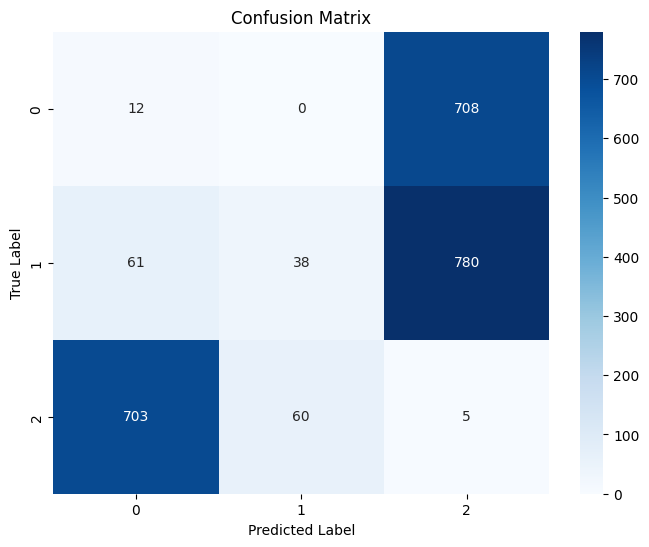

In [61]:
# Create the testing confusion matrix
cm = confusion_matrix(test_results['expected_label'], test_results['predicted_label'],labels=["ENTAILMENT","NEUTRAL","CONTRADICTION"])

# Visualize the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d",cmap="Blues")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [62]:
report_dict = classification_report(test_results['expected_label'], test_results['predicted_label'], output_dict=True)
report_df = pd.DataFrame(report_dict).transpose() 
report_df.columns.name = 'label'
report_df

label,precision,recall,f1-score,support
CONTRADICTION,0.003349,0.006510,0.004423,768.000000
ENTAILMENT,0.015464,0.016667,0.016043,720.000000
NEUTRAL,0.387755,0.043231,0.077789,879.000000
accuracy,0.023236,0.023236,0.023236,0.023236
macro avg,0.135523,0.022136,0.032752,2367.000000
weighted avg,0.149786,0.023236,0.035202,2367.000000


In [63]:
metrics_by_type = test_results.groupby('type').apply(compute_metrics_by_type).reset_index()
metrics_by_type.columns.name = 'ID'
metrics_by_type

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning

ID,type,accuracy,precision,recall,f1_score
0,type1_again,0.02,0.01,0.02,0.01
1,type1_possessive,0.07,0.01,0.07,0.02
2,type2_again,0.02,0.02,0.02,0.02
3,type2_possessive,0.00,0.00,0.00,0.00
4,type3_again,0.07,0.35,0.07,0.11
5,type3_possessive,0.00,0.00,0.00,0.00
6,type4_possessive,0.04,0.00,0.04,0.01
7,type5_again,0.00,0.00,0.00,0.00
8,type5_possessive,0.01,0.00,0.01,0.01


## FacebookAI/roberta-large-mnli

In [82]:
checkpoint = "FacebookAI/roberta-large-mnli"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

In [83]:
model = AutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=3)

Some weights of the model checkpoint at FacebookAI/roberta-large-mnli were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [84]:
tokenized_train_ds = train_ds.map(lambda x: preprocess_function(x, tokenizer), batched=True)
tokenized_val_ds = val_ds.map(lambda x: preprocess_function(x, tokenizer), batched=True)
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

Map:   0%|          | 0/13680 [00:00<?, ? examples/s]

Map:   0%|          | 0/3420 [00:00<?, ? examples/s]

In [29]:
len(val_ds)

2168

In [85]:
random_seed = random.randint(0, 2**32 - 1)
training_args = TrainingArguments(
    output_dir="./results",
    num_train_epochs=1, # Set the number of epochs to 1
    logging_steps=200,
    evaluation_strategy="steps",
    eval_steps=200,
    # evaluation_strategy="epoch",  # Evaluate during training
    # evaluation_strategy="no",
    save_strategy="epoch",  # Save the model at the end of each epoch
    # load_best_model_at_end=True,  # Load the best model at the end of training
    report_to="none",
    fp16=True,
    seed=random_seed
)
trainer = Trainer(
    model,
    args=training_args,
    train_dataset=tokenized_train_ds,
    eval_dataset=tokenized_val_ds,
    compute_metrics=compute_metrics,
    data_collator=data_collator,
    tokenizer=tokenizer,
    callbacks=[]
)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-85-698a483ddfe9>:16: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [86]:
trainer.train()

Step,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Score,Gmean
200,0.474800,0.206427,0.952047,0.953401,0.952047,0.952331,0.965725
400,0.332600,0.190800,0.969883,0.972119,0.969883,0.970128,0.979026
600,0.181400,0.170102,0.966374,0.969362,0.966374,0.966818,0.976795
800,0.124900,0.116466,0.981287,0.981614,0.981287,0.981269,0.986523
1000,0.094400,0.056724,0.991813,0.991851,0.991813,0.991822,0.993871
1200,0.058700,0.087679,0.988304,0.988358,0.988304,0.988287,0.991398
1400,0.047500,0.033187,0.994444,0.994539,0.994444,0.994454,0.996175
1600,0.055000,0.024403,0.995906,0.995954,0.995906,0.995911,0.997167


TrainOutput(global_step=1710, training_loss=0.16204024086221616, metrics={'train_runtime': 3922.2796, 'train_samples_per_second': 3.488, 'train_steps_per_second': 0.436, 'total_flos': 1.274886412591104e+16, 'train_loss': 0.16204024086221616, 'epoch': 1.0})

In [68]:
trainer.train()

Step,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Score,Gmean
200,0.405100,0.176783,0.966959,0.969815,0.966959,0.967386,0.977270
400,0.210300,0.088936,0.988304,0.988372,0.988304,0.988311,0.991488
600,0.078700,0.051106,0.991813,0.991935,0.991813,0.991827,0.994350
800,0.088700,0.037735,0.993567,0.993629,0.993567,0.993570,0.995511
1000,0.076900,0.048800,0.992690,0.992844,0.992690,0.992705,0.995006
1200,0.039700,0.029933,0.994737,0.994806,0.994737,0.994744,0.996358
1400,0.036900,0.017991,0.997076,0.997108,0.997076,0.997079,0.998015
1600,0.016300,0.015712,0.997661,0.997681,0.997661,0.997663,0.998412


TrainOutput(global_step=1710, training_loss=0.11233260401508265, metrics={'train_runtime': 3920.6578, 'train_samples_per_second': 3.489, 'train_steps_per_second': 0.436, 'total_flos': 1.274886412591104e+16, 'train_loss': 0.11233260401508265, 'epoch': 1.0})

In [45]:
trainer.train()

Step,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Score,Gmean
200,0.415000,0.165543,0.962281,0.965294,0.962281,0.962693,0.973414
400,0.302200,0.183648,0.966959,0.967810,0.966959,0.967105,0.975971
600,0.172800,0.172620,0.969591,0.970200,0.969591,0.969753,0.977287
800,0.084100,0.069898,0.988889,0.989164,0.988889,0.988943,0.992184
1000,0.092700,0.021725,0.996199,0.996239,0.996199,0.996203,0.997366
1200,0.040900,0.030639,0.994737,0.994840,0.994737,0.994746,0.996427
1400,0.040400,0.028239,0.995322,0.995403,0.995322,0.995329,0.996824
1600,0.027600,0.022823,0.996491,0.996537,0.996491,0.996496,0.997618


TrainOutput(global_step=1710, training_loss=0.1389521998968738, metrics={'train_runtime': 3924.6863, 'train_samples_per_second': 3.486, 'train_steps_per_second': 0.436, 'total_flos': 1.274886412591104e+16, 'train_loss': 0.1389521998968738, 'epoch': 1.0})

In [23]:
trainer.train()   

Step,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Score,Gmean
100,0.579500,0.192009,0.964620,0.966564,0.964620,0.964910,0.974803
200,0.250500,0.165543,0.962281,0.965294,0.962281,0.962693,0.973414
300,0.333500,0.164875,0.964327,0.966764,0.964327,0.964685,0.974756
400,0.270800,0.183648,0.966959,0.967810,0.966959,0.967105,0.975971
500,0.207500,0.117007,0.982749,0.983019,0.982749,0.982756,0.986940
600,0.138000,0.172620,0.969591,0.970200,0.969591,0.969753,0.977287
700,0.134200,0.044299,0.992105,0.992119,0.992105,0.992109,0.994093
800,0.034000,0.069898,0.988889,0.989164,0.988889,0.988943,0.992184
900,0.103700,0.057799,0.988889,0.989224,0.988889,0.988939,0.992292
1000,0.081600,0.021725,0.996199,0.996239,0.996199,0.996203,0.997366


TrainOutput(global_step=1710, training_loss=0.13895218430729636, metrics={'train_runtime': 5512.4525, 'train_samples_per_second': 2.482, 'train_steps_per_second': 0.31, 'total_flos': 1.274886412591104e+16, 'train_loss': 0.13895218430729636, 'epoch': 1.0})

In [93]:
trainer.save_model("roberta-large-mnli")

In [ ]:
# uploading to HuggingFace 
from huggingface_hub import login

login(new_session=False, # Won’t request token if one is already saved on machine
write_permission=True, # Requires a token with write permission
token="", # The name of your token
add_to_git_credential=True)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in 'login': write_permission. Will not be supported from version '1.0'.

Fine-grained tokens added complexity to the permissions, making it irrelevant to check if a token has 'write' access.
  warnings.warn(message, FutureWarning)
Token has not been saved to git credential helper.


Cannot authenticate through git-credential as no helper is defined on your machine.
You might have to re-authenticate when pushing to the Hugging Face Hub.
Run the following command in your terminal in case you want to set the 'store' credential helper as default.

git config --global credential.helper store

Read https://git-scm.com/book/en/v2/Git-Tools-Credential-Storage for more details.


In [94]:
from huggingface_hub import HfApi
api = HfApi()

# Upload all the content from the local folder to your remote Space.
# By default, files are uploaded at the root of the repo
api.upload_folder(
    folder_path='/kaggle/working/roberta-large-mnli',
    repo_id="ConditionalNLI/Exp4_roberta-large-mnli",
    commit_message="Run 3"
)

training_args.bin:   0%|          | 0.00/5.30k [00:00<?, ?B/s]

Upload 2 LFS files:   0%|          | 0/2 [00:00<?, ?it/s]

model.safetensors:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/ConditionalNLI/Exp4_roberta-large-mnli/commit/b4fedb4062e61875a8769a67264bb29b62b8e974', commit_message='Run 3', commit_description='', oid='b4fedb4062e61875a8769a67264bb29b62b8e974', pr_url=None, repo_url=RepoUrl('https://huggingface.co/ConditionalNLI/Exp4_roberta-large-mnli', endpoint='https://huggingface.co', repo_type='model', repo_id='ConditionalNLI/Exp4_roberta-large-mnli'), pr_revision=None, pr_num=None)

### Inferencing

In [71]:
from transformers import pipeline
from datasets import load_dataset, Dataset
from transformers.pipelines.pt_utils import KeyDataset, KeyPairDataset
import torch

In [72]:
if torch.cuda.is_available():
    print("GPU is available!")
    device = torch.device("cuda")
else:
    print("GPU is not available, using CPU")
    device = torch.device("cpu")

GPU is available!


In [95]:
checkpoint = "ConditionalNLI/Exp4_roberta-large-mnli"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)
model = AutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=3)

model.safetensors:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

In [96]:
gen = pipeline('text-classification', model=model, tokenizer=tokenizer, device=device)

Device set to use cuda


In [97]:
id_num = 0
test_results = pd.DataFrame(columns = ['id', 'premise', 'hypothesis', 'type', 'expected_label', 'predicted_label'])

for predicted in gen(KeyPairDataset(test_ds,'premise', 'hypothesis'), batch_size=8, truncation=True):
    if id_num % 100 == 0:
        print(id_num)
    test_results.loc[id_num] = [str(id_num), test_ds['premise'][id_num], test_ds['hypothesis'][id_num], test_ds['type'][id_num], test_ds['label'][id_num], predicted['label']]
    id_num += 1

len(test_results)

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300


2367

In [55]:
test_results

,id,premise,hypothesis,type,expected_label,predicted_label
0,0,"If Charlotte passes her driving test, her parents will buy her a car.",Charlotte has parents.,type5_possessive,ENTAILMENT,CONTRADICTION
1,1,"It's not the case that if Charlotte passes her driving test, her parents will buy her a car.",Charlotte has parents.,type5_possessive,ENTAILMENT,CONTRADICTION
2,2,"Sam believes that if Charlotte passes her driving test, her parents will buy her a car.",Charlotte has parents.,type5_possessive,ENTAILMENT,CONTRADICTION
3,3,"Is it true that if Charlotte passes her driving test, her parents will buy her a car?",Charlotte has parents.,type5_possessive,ENTAILMENT,CONTRADICTION
4,4,"If Lily takes the train to the city, her friend will meet her at the station.",Lily has a friend.,type5_possessive,ENTAILMENT,CONTRADICTION
...,...,...,...,...,...,...
2362,2362,"If Sophia decides to attend the concert, his best friend will drive him there.",Sophia has a close friend.,type5_possessive,NEUTRAL,CONTRADICTION
2363,2363,"It's not the case that if Sophia decides to attend the concert, his best friend will drive him there.",Sophia has a close friend.,type5_possessive,NEUTRAL,CONTRADICTION
2364,2364,"Sam believes that if Sophia decides to attend the concert, his best friend will drive him there.",Sophia has a close friend.,type5_possessive,NEUTRAL,CONTRADICTION
2365,2365,"Is it true that if Sophia decides to attend the concert, his best friend will drive him there?",Sophia has a close friend.,type5_possessive,NEUTRAL,CONTRADICTION


In [98]:
test_results.to_csv('exp4_roberta_test_results_run3.csv')

In [77]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

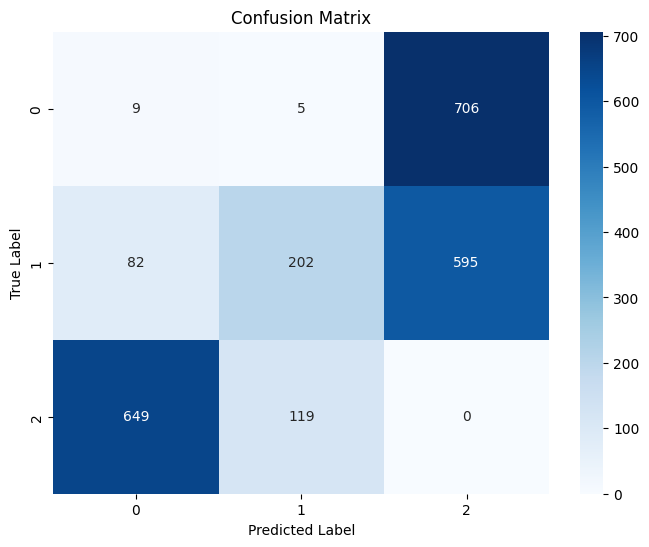

In [99]:
# Create the testing confusion matrix
cm = confusion_matrix(test_results['expected_label'], test_results['predicted_label'],labels=["ENTAILMENT","NEUTRAL","CONTRADICTION"])

# Visualize the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d",cmap="Blues")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [100]:
report_dict = classification_report(test_results['expected_label'], test_results['predicted_label'], output_dict=True)
report_df = pd.DataFrame(report_dict).transpose() 
report_df.columns.name = 'label'
report_df

label,precision,recall,f1-score,support
CONTRADICTION,0.000000,0.000000,0.000000,768.000000
ENTAILMENT,0.012162,0.012500,0.012329,720.000000
NEUTRAL,0.619632,0.229807,0.335270,879.000000
accuracy,0.089142,0.089142,0.089142,0.089142
macro avg,0.210598,0.080769,0.115866,2367.000000
weighted avg,0.233804,0.089142,0.128255,2367.000000


In [101]:
metrics_by_type = test_results.groupby('type').apply(compute_metrics_by_type).reset_index()
metrics_by_type.columns.name = 'ID'
metrics_by_type

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning

ID,type,accuracy,precision,recall,f1_score
0,type1_again,0.27,0.24,0.27,0.26
1,type1_possessive,0.29,0.15,0.29,0.19
2,type2_again,0.10,0.07,0.10,0.08
3,type2_possessive,0.00,0.00,0.00,0.00
4,type3_again,0.08,0.28,0.08,0.08
5,type3_possessive,0.07,0.01,0.07,0.01
6,type4_possessive,0.13,0.05,0.13,0.07
7,type5_again,0.00,0.00,0.00,0.00
8,type5_possessive,0.01,0.00,0.01,0.00
